<a href="https://colab.research.google.com/github/wvirany/mini_projects/blob/main/deep_learning/zero_to_hero/building_makemore_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# makemore, part 3

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-09-26 12:57:52--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2024-09-26 12:57:53 (41.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# build the dataset
block_size = 3 # context length

def build_dataset(words, block_size):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [9]:
import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 5/3 / ((n_embed * block_size)**0.5)  # kaiming initialization
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01   # no bias term when using batch normalization; when un-commenting, make sure to add to params list
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# BatchNorm parameters
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bn_gain, bn_bias]

print(f"Number of parameters: {sum(p.nelement() for p in params)}") # total number of parameters

for p in params:
  p.requires_grad = True

Number of parameters: 12097


In [13]:
# training the neural net
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_b, Y_b = X_train[ix], Y_train[ix]  # batch X, Y

  # forward pass
  emb = C[X_b]
  embcat = emb.view(emb.shape[0], -1) # concatenate embedding vectors

  # Linear Layer
  pre_activation = embcat @ W1 # + b1 - pre-activation units (remove b1 because it gets subtracted when performing batch normalization)

  # BatchNorm Layer
  # ============================================================================
  bn_mean_i = pre_activation.mean(0, keepdim=True)
  bn_std_i = pre_activation.std(0, keepdim=True)

  pre_activation = bn_gain * (pre_activation - bn_mean_i) / (bn_std_i + 1e-5) + bn_bias

  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
    bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
  # ============================================================================

  # Activation Layer
  h = torch.tanh(pre_activation) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Y_train[ix]) # loss function

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  losses.append(loss.log10().item())

  break

      0/ 200000: 3.3239


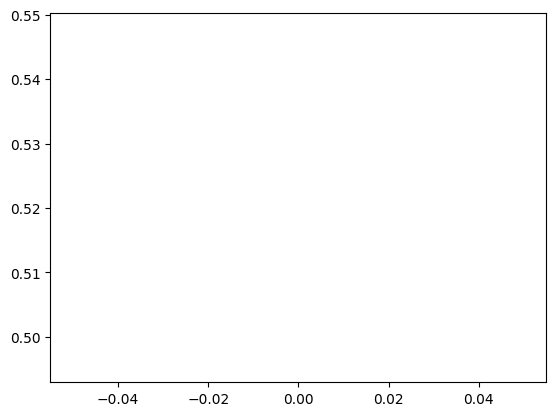

In [14]:
plt.plot(losses)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  pre_activation = embcat @ W1 #+ b1 # pre-activation units
  pre_activation = bn_gain * (pre_activation - bn_mean_running) / bn_std_running + bn_bias # batch normalization
  h = torch.tanh(pre_activation)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.270019769668579
val 3.269137144088745


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:

    # forward pass the neural net
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)

    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

erbujgmyazzhzelvndhfyllwqetvrsjejdrljg.
azcjedoeliizsmpqppalekepxvqnwxarveptzcmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjejqqxntpucfkubzkgvdcrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoecmpfhdxjfqyxoeobhggpcixjsfcueywh.
hmrjolvii.
qirf.
wvpkxwvlla.
odtabfsztpnegoikvsbmitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudw.
iwbdnihzvorlq.
cjakepxugniagcfpppfmiipzjgvonxet.
jynnblkskzporygnogsvmwosfzybsyknvmjcxtxncjbmu.
jtew.
aow.
copmrlxkkdcqbcep.
ccdfivsnicimhtecmokagouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuqcxzhosy.
sj.


## PyTorch-ifying

In [17]:
# ------------ SUMMARY ------------

In [35]:
# Training a deeper network, making it look like PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      x_mean = x.mean(0, keepdim=True)              # batch mean
      x_var = x.var(0, keepdim=True, unbiased=True) # batch variance
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # normalize to unit variance
    self.out = self.gamma * x_hat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [46]:
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # dimension of character embedding vectors
n_hidden = 100 # number of neurons in hidden layer of the MLP

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1 # When using batch norm in the last layer, change gamma instead
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # kaiming initialization for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
  p.requires_grad = True

Total number of parameters: 47551


In [47]:
# Training the neural net

max_steps = 200000
batch_size = 32
losses = []
ud_ratio = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_b, Y_b = X_train[ix], Y_train[ix]

  # forward pass
  emb = C[X_b]    # embed characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate embedding vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Y_b)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 ==0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  losses.append(loss.log10().item())
  with torch.no_grad():
    ud_ratio.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1042
  30000/ 200000: 1.9646
  40000/ 200000: 2.2145
  50000/ 200000: 2.2262
  60000/ 200000: 1.7340
  70000/ 200000: 2.1743
  80000/ 200000: 2.1895
  90000/ 200000: 1.8283
 100000/ 200000: 2.3646
 110000/ 200000: 2.2026
 120000/ 200000: 2.1039
 130000/ 200000: 1.8566
 140000/ 200000: 1.8049
 150000/ 200000: 1.9258
 160000/ 200000: 1.8757
 170000/ 200000: 1.8330
 180000/ 200000: 2.2324
 190000/ 200000: 2.0522


layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 14.06%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 16.84%
layer 8 (      Tanh): mean -0.00, std 0.75, saturated: 15.81%
layer 11 (      Tanh): mean +0.02, std 0.77, saturated: 16.75%
layer 14 (      Tanh): mean -0.02, std 0.79, saturated: 18.91%


Text(0.5, 1.0, 'activation distribution')

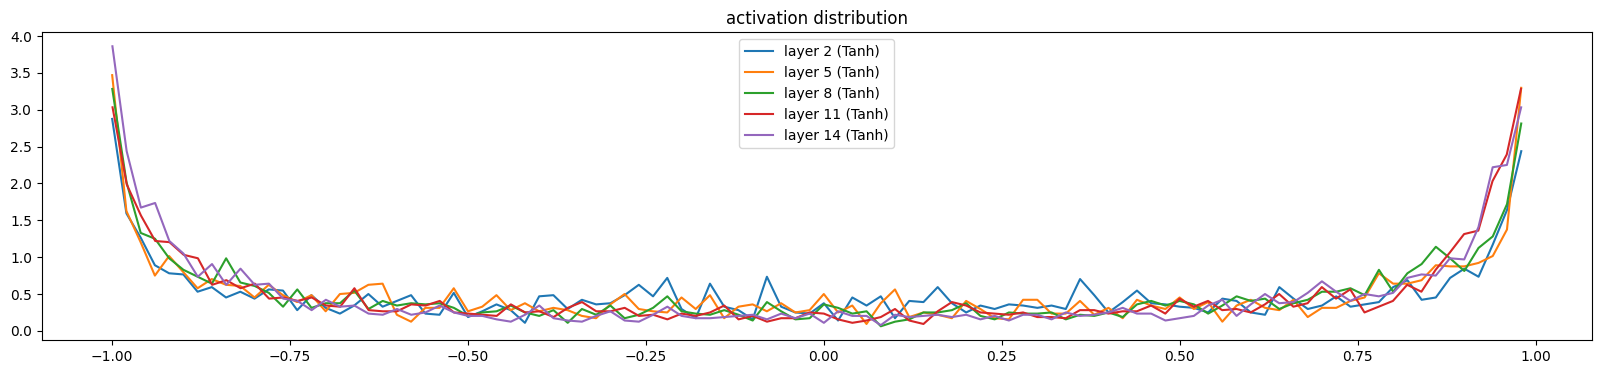

In [48]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

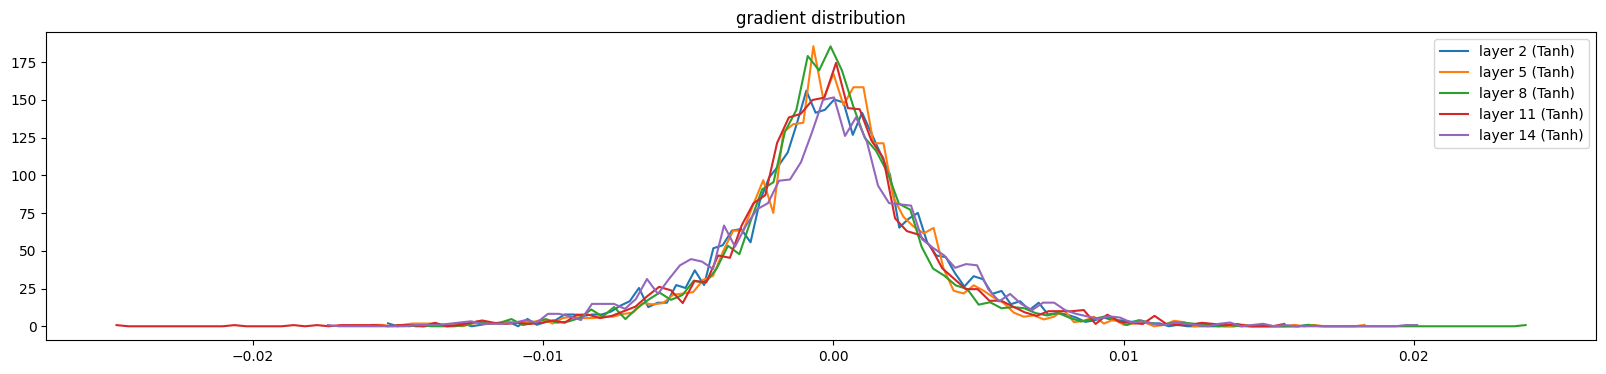

In [49]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.496443e-02 | grad:data ratio 1.370268e-02
weight  (30, 100) | mean +0.000084 | std 7.878289e-03 | grad:data ratio 1.922244e-02
weight (100, 100) | mean +0.000060 | std 5.057851e-03 | grad:data ratio 2.049041e-02
weight (100, 100) | mean -0.000087 | std 5.180276e-03 | grad:data ratio 2.133905e-02
weight (100, 100) | mean +0.000043 | std 5.201565e-03 | grad:data ratio 2.196100e-02
weight (100, 100) | mean -0.000013 | std 5.238893e-03 | grad:data ratio 2.278768e-02
weight  (100, 27) | mean +0.000054 | std 9.173456e-03 | grad:data ratio 2.777520e-02


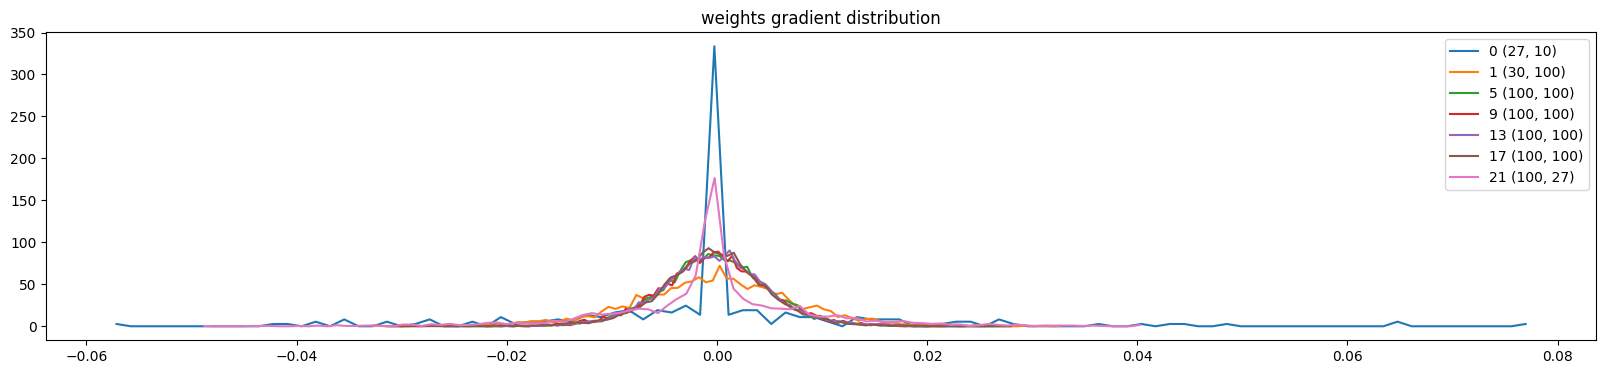

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


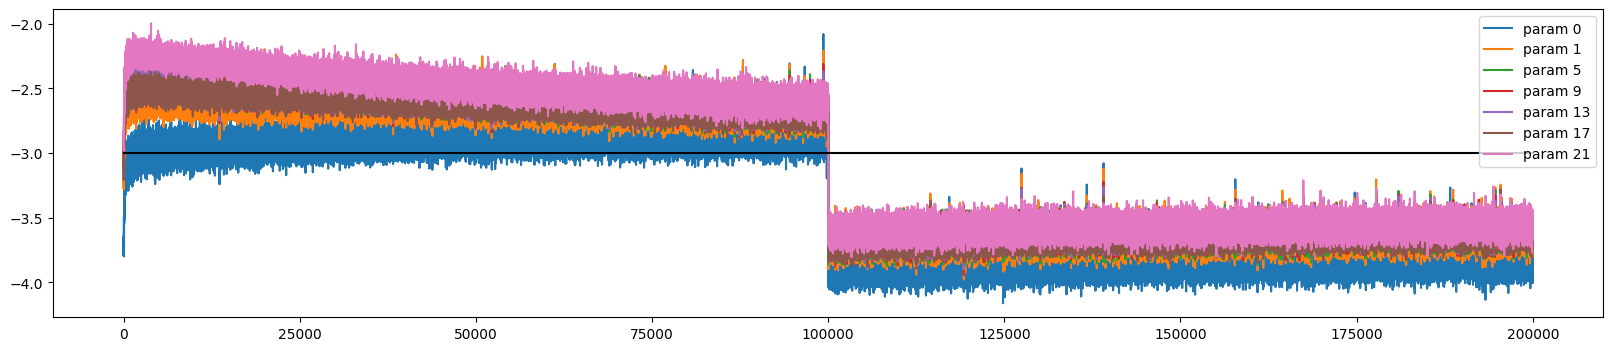

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud_ratio[j][i] for j in range(len(ud_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(ud_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.012324094772339
val 2.084045648574829


In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mona.
kmyah.
see.
madhayla.
reisra.
ejdra.
gradee.
daelin.
shyloni.
eden.
est.
aarielle.
malaia.
noshubergiaghan.
trick.
welle.
jose.
cayu.
zayven.
kylene.
